In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import cv2

In [4]:
# Load images and labels
images = np.load('/kaggle/input/crowd-counting/images.npy')  # Shape should be (num_samples, height, width, channels)
labels_df = pd.read_csv('/kaggle/input/crowd-counting/labels.csv')  # Assuming it has columns 'id' and 'count'

# Check if the number of images matches the number of labels
assert len(images) == len(labels_df), "Mismatch between number of images and labels"

In [5]:
# Prepare labels (assuming 'id' corresponds to the index of images)
labels = labels_df['count'].values

# Normalize images
images = images.astype('float32') / 255.0

(480, 640, 3)
Resized shape: (224, 224, 3)


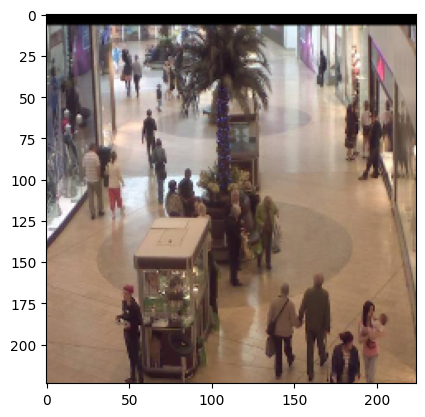

In [6]:
img = images[0]
print(images[0].shape)
# Resize images to 224x224 using cv2.resize
images_resized = [cv2.resize(m, (224, 224)) for m in images]

# Display the first image
img = images_resized[0]
print("Resized shape:", img.shape)
plt.imshow(img)
plt.show()

### Model Class (VGG-16)

In [7]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            #Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096), nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(inplace=True), nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    def backward(self, loss, optimizer):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def train(self, dataloader, criterion, optimizer, epochs=1, device='cpu'):
        self.to(device)
        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.train(dataloader, criterion, optimizer)
        for epoch in range(epochs):
            total_loss = 0.0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.forward(inputs)
                loss = criterion(outputs, labels)
                self.backward(loss, optimizer)
                total_loss += loss.item()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.df}")

    def predict(self, input_tensor, device="cpu"):
        self.eval()
        input_tensor = input_tensor.to(device)
        with torch.no_grad():
            output = self.forward(input_tensor)
            _, predicted = torch.max(output, 1)
        return predicted.cpu().numpy()

    def visualize(self, input_tensor):
        image = input_tensor.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

In [8]:
# Define model, optimizer, and loss
model = VGG16(num_classes=10)  # Example for 10 classes
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [9]:
image_tensors = torch.tensor(images_resized[0], dtype=torch.float32)
image_tensors = image_tensors.permute(2, 0, 1)
image_tensors.shape

torch.Size([3, 224, 224])

In [10]:
# Dummy data for illustration
dummy_input = image_tensors  # Example input
dummy_label = labels[0]  # Example label
dummy_dataset = [(dummy_input, dummy_label)]  # Mock dataset
dummy_dataloader = torch.utils.data.DataLoader(dummy_dataset, batch_size=1)

In [11]:
dummy_input.shape

torch.Size([3, 224, 224])

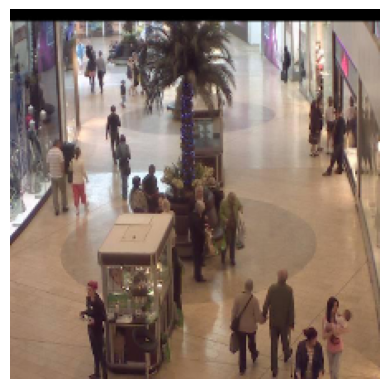

In [12]:
# Visualize the input
model.visualize(dummy_input)

In [13]:
# Train the model
model.train(dummy_dataloader, criterion, optimizer, epochs=1)

RecursionError: maximum recursion depth exceeded while calling a Python object